<a href="https://colab.research.google.com/github/eduardalexandrut/llm-iq-test/blob/main/LLM_visual_iq_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LLM Visual IQ Testing

## Introduction

The purpouse of this notebook is to test several multimodal LLM on visual iq test.
Let's start by installing the following packages:
- `Transformers`: Provides pre-trained models and tokenizers for NLP and multimodal tasks. We’ll use it to load models and preprocess text and images for LLM testing.
- `PIL`: Handles image loading and manipulation. We’ll use it to preprocess and display images in multimodal model evaluation.
- `Datasets`: Offers easy access to standardized datasets from the Hugging Face Hub. We’ll use it to load datasets for training and evaluating models.

In [1]:
!pip install -U git+https://github.com/huggingface/transformers
!pip install PIL
!pip install datasets

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-ua2bf99d
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-ua2bf99d
  Resolved https://github.com/huggingface/transformers to commit a06a0d12636756352494b99b5b264ac9955bc735
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 25.7 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-4.47.0.dev0-py3-none-any.whl size=10051734 sha256=165466adef7cce3462310dbf6cb471641625d6ca89508b267313dd3a7d474de8
  Stored in directory: /tmp/pip-ephem-wheel-cache-kp2qzl5u/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully 

Now let's import the necessary modules from these packages:
- `AutoTokenizer`: Responsible for converting input text into tokens that the model can process, adapting to the specific tokenization requirements of the model.
- `AutoProcessor`: Used to preprocess inputs, often across modalities like text and image, ensuring compatibility with multimodal models.
- `Image`: Used for opening, manipulating, and displaying image files, essential for handling image data in multimodal model testing.
- `AutoModelForCausalLM`: Provides the pre-trained language model for generating predictions in a causal (autoregressive) manner, typically for text generation tasks.
- `requests`: A module for sending HTTP requests, often used to fetch data from APIs or retrieve images and other resources over the internet.
-`load_datasets`: Loads datasets from the Hugging Face Hub or local files, enabling access to standardized datasets for model training and evaluation.

In [4]:
from transformers import AutoTokenizer, AutoProcessor, AutoModelForCausalLM, set_seed
from PIL import Image
import requests
from datasets import load_dataset
import re
import json

In [5]:
set_seed(42)

## Dataset

Now we'll download `MENSA-visual-iq-test` from HuggingFace. This dataset contains several visual iq tests from MENSA. The dataset is made up of 3 subsets:

- MENSA Norway: 35 instances.
- MENSA Denmark: 38 instances.
- MENSA Sweden: 25 instances.

We'll use the `load_dataset` function that we've imported before to load the dataset:

In [6]:
dataset = load_dataset("eduardtoni/MENSA-visual-iq-test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset['train']

Dataset({
    features: ['question_id', 'question_path', 'question_img', 'difficulty', 'subset', 'correct_answer_img', 'correct_answer', 'choices_letter', 'choices_images', 'multiple_answer_img', 'multiple_answer_path', 'explanations'],
    num_rows: 98
})

Every entry in the dataset represents a question, and has the following features:

- `question_id`: Unique identifier.
- `question_path`: The path to the image representing the question.
- `question_img`: A PIL image of the question.
- `subset`: The subset of which the question is part of.
- `difficulty`: An integer between 1 and 3 representing the difficulty of the question.
- `correct_answer_img`: A PIL image of the correct answer image.
- `correct_answer`: The path to the correct answer image.
- `choiches_letter`: An array of characters with all the possible answers to a question (e.x. 'A', 'B', 'C',...)
- `choiches_images`: An array containing the paths to the images of all possible answers to a question.
- `multiple_answer_img`: A PIL image that contains all the possible answers to a question. Each one is labeled with corresponfing letter.
- `multiple_answer_path`: The path to the multiple answer image.
- `explanations`: An array containing different explanations for the reason why a specific answer is the correct one.

The dataset has 98 instances in total.

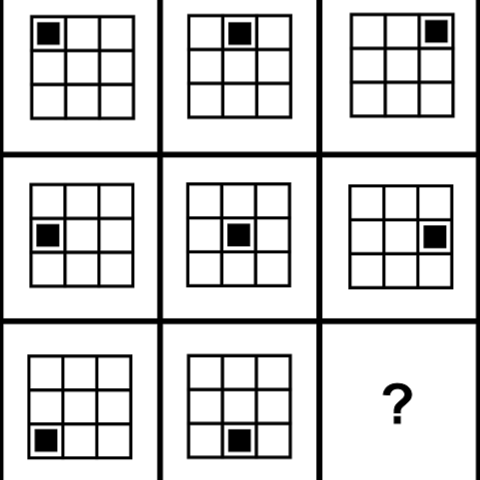

In [ ]:
dataset['train'][0]['question_img']

This is a question image.

The following image is the correct answer to the previous question.

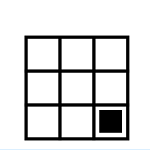

In [ ]:
dataset['train'][0]['correct_answer_img']

The following image is the multiple answer image of the previous question, containing all the possible labeled answers.

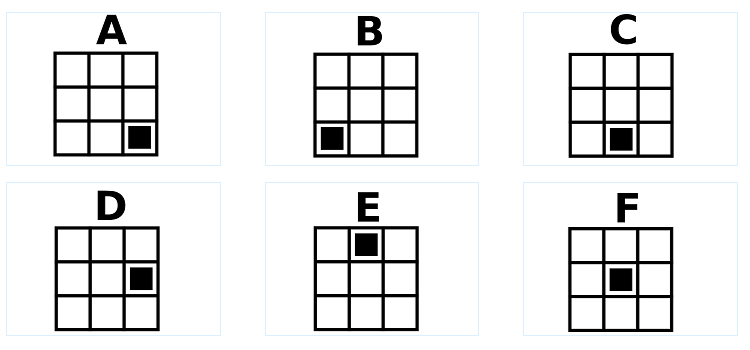

In [ ]:
dataset['train'][0]['multiple_answer_img']

## Helper Functions

Next, we'll define some functions that will help us dealing with the work load.

The first function we define is `convert_answer_to_json`. This function will take as input the answer generated by a model, and extract the json answer and create a json object.

In [8]:
def convert_answer_to_json(answer):
    assistant = '\nassistant\n'
    parts = answer.split(assistant, 1)
    res = parts[1].strip() if len(parts) > 1 else None

    # Remove Markdown-style ```json``` delimiters if present
    cleaned_string = re.sub(r"```json|```", "", res).strip() if res else None

    if cleaned_string:
        try:
            json_object = json.loads(cleaned_string)  # Parse the cleaned string

            # Clean the explanation field
            if "explanation" in json_object:
                json_object["explanation"] = extract_and_clean_explanation(cleaned_string)

            return json_object
        except json.JSONDecodeError as e:
            print(f"JSON decode error: {e}")
            print(res)
            return None
    else:
        return None

We ask the model to return the answer to the question and an explanation. The answer must be formatted in the following json structure:

{

  "answer": "The letter corresponding to the answer",

  "explanation":"The reason why the model has chosen this answer as the correct one."

}

Sometimes, even with prompt enginering, the models generate an answer that is not correctly formated and breaks the json structure, by intoducing double quotes`""` inside the `explanation` field. The purpouse of the following function `extract_and_clean_explanation` is to clean up the `explanation` field by replacing double quotes with single quotes `''`.

In [9]:
def extract_and_clean_explanation(text):
    # Locate the start of the explanation content
    start = text.find('explanation": "') + len('explanation": "')

    # Find the end quote of the explanation text
    end = text.find('"', start)

    # Extract the content between the quotes
    explanation_content = text[start:end]

    # Remove all double quotes from the explanation content
    cleaned_explanation = explanation_content.replace('"', '')

    return cleaned_explanation

We define a function called `test_split()`. This function takes as input the following arguments:
- `dataset`: The dataset on which the model will be tested.
- `subset`: The subset of the dataset(Norway, Sweden, Denmark).
- `start`: The start index.
- `end`: The end index.
- `model`: The model we will test.
- `prompt`: The prompt that will be given to the model.
- `processor`: The processor of the model.

The function the returns an array of answers as json objects.

In [2]:
def test_split(dataset, subset=None, start=None, end=None, model=None, prompt=None, processor=None):
    # Select the dataset split
    if subset is None:
        dataset_subset = dataset['train']
    else:
        # Filter the 'train' subset based on the specified 'subset' value
        dataset_subset = dataset['train'].filter(lambda x: x['subset'] == subset)

    # Determine the range of indices
    if start is None:
        start = 0
    if end is None:
        end = len(dataset_subset)

    answers_json = []
    for i in range(start, end):
        question_img = dataset_subset[i]['question_img']
        answer_img = dataset_subset[i]['multiple_answer_img']

        # Apply the provided prompt template if available, otherwise use a default
        text_prompt = processor.apply_chat_template(prompt, add_generation_prompt=True)

        # Prepare inputs with text and images
        inputs = processor(
            text=text_prompt,
            images=[question_img, answer_img],
            return_tensors="pt"
        )

        # Send inputs to the appropriate device
        inputs = inputs.to("cuda")

        # Generate output from the model
        output_ids = model.generate(**inputs, max_new_tokens=512)

        # Process generated text
        generated_text = [
            output_ids[len(input_ids):]
            for input_ids, output_ids in zip(inputs.input_ids, output_ids)
        ]
        output_text = processor.batch_decode(output_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

        # Convert output to JSON
        json_answer = convert_answer_to_json(output_text[0])
        if json_answer:
            json_answer['question_id'] = i
            answers_json.append(json_answer)
        else:
            print(f"No valid JSON found in the generated text from question {i}.")

    return answers_json

The following `get_score` function gets the answers given by a LLM and returns a tuple made of the number of correct answers, the percentage of correct answers and the iq score obtained.

In [11]:
def get_score(answers, dataset):
  num_correct_answers = sum(answer['answer'] == dataset['train'][answer['question_id']]['correct_answer'] for answer in answers)
  percentage_correct_answers = (num_correct_answers/len(answers)) * 100
  iq_score = 0
  return (num_correct_answers, percentage_correct_answers, iq_score)

The following `save_results` function will be used to save the result of a test inside a json file. The object will have the following attributes:
- `model`:
- `prompt`:
- `split`:
- `answers`:
- `correct_answers`:
- `percentage_score`:
- `iq_score`:

In [10]:
def save_results(model, prompt, split, answers, correct_answers, percentage_score, iq_score):
  #Create json object representing a test.
  result = {
      'model': model,
      'prompt': prompt,
      'split': split,
      'answers': answers,
      'correct_answers': correct_answers,
      'percentage_score': percentage_score,
      'iq_score': iq_score
  }

  #Extract the name of the prompt used.
  prompt_name = next(prompt.keys())

  #Save result inside a json file.
  with open(f"/results/{model}/{prompt_name}.json", "w") as out_file:
    for ans in mensa_norway_answers:
      json_line = json.dumps(ans)
      out_file.write(json_line + "\n")
  return

## Prompts

One of the goals of this paper is to try different prompts and prompting techniques, in order to see how it affects the performance of a model. The following dictionary `prompt` contains all the different prompts we will test:

In [12]:
prompts = {
    'prompt_1': [
        {
            'role': 'system',
            'content': 'Please reason step by step'
        },
        {
            'role': 'user',
            'content': [
                {
                    'type': 'image',
                },
                {
                    'type': 'text',
                    'text': 'Analyze the previous image: a grid of images with one cell marked with the symbol ?. Identify any visual or logical patterns within rows and columns to understand what the missing cell should contain.'
                },
                {
                    'type': 'image',
                },
                {
                    'type': 'text',
                    'text': 'Analyze the previous image: This image shows all possible answer choices. Each choice has a unique drawing labeled with a letter above it, which you can select from to complete the missing cell in the first image based on the identified pattern.'
                },
                {
                    'type': 'text',
                    'text': 'Using the two images, determine the pattern in the first image and select the letter above the drawing in the second image that best completes the missing cell. Return your answer in the following JSON format: {"answer": your selected letter, "explanation": your reasoning here}. Do not use "" symbols within the explanation inside the json.'
                }
            ]
        }
    ],
    'prompt_2': [
        {
            'role': 'system',
            'content': 'Please reason step by step'
        },
        {
            'role': 'user',
            'content': [
                {
                    'type': 'image',
                },
                {
                    'type': 'text',
                    'text': 'Analyze the previous image: a grid of images with one cell marked with the symbol ?. Identify any visual or logical patterns within rows and columns to understand what the missing cell should contain.'
                },
                {
                    'type': 'image',
                },
                {
                    'type': 'text',
                    'text': 'Analyze the previous image: This image shows all possible answer choices. Each choice has a unique drawing labeled with a letter above it, which you can select from to complete the missing cell in the first image based on the identified pattern.'
                },
                {
                    'type': 'text',
                    'text': 'Using the two images, determine the pattern in the first image and select the letter above the drawing in the second image that best completes the missing cell. Return your answer in the following JSON format: {"answer": your selected letter}.'
                }
            ]
        }
    ]
}

## QwenV2

The first model we will test is Qwen2-VL-2B-Instruct.

In [13]:
from transformers import Qwen2VLForConditionalGeneration

Load Qwen2-VL-2B-Instruct model and encoder.

In [14]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    torch_dtype = "auto",
    device_map = "auto",
    trust_remote_code=True
)
processor = AutoProcessor.from_pretrained(
    "Qwen/Qwen2-VL-2B-Instruct",
    trust_remote_code=True
)

The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
image = dataset['train'][0]['question_img']
possible_sol = dataset['train'][0]['multiple_answer_img']
messages = [
        {'role': 'system', 'content': 'Please reason step by step'},
        {'role': 'user',
        'content': [
            {
                'type': 'image',
            },
            {
                'type':'text',
                'text':'Analyze the previous image: a grid of images with one cell marked with the symbol ?. Identify any visual or logical patterns within rows and columns to understand what the missing cell should contain.'
            },
            {
                'type': 'image',
            },
            {
                'type':'text',
                'text':'Analyze the previous image:This image shows all possible answer choices. Each choice has a unique drawing labeled with a letter above it, which you can select from to complete the missing cell in the first image based on the identified pattern.'
            },
            {
                'type': 'text',
                'text': 'Using the two images, determine the pattern in the first image and select the letter above the drawing in the second image that best completes the missing cell. Return your answer in the following JSON format: {"answer": your selected letter, "explanation": your reasoning here)}. Do not use \"\" symbols within the explanation inside the json.'
            }
        ]
    }
]


text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
inputs = processor(
    text = text_prompt,
    images = [image, possible_sol],
    return_tensors = "pt"
)

# Inference: Generation of the output
inputs = inputs.to("cuda")
output_ids = model.generate(**inputs, max_new_tokens = 1024)

generated_text = [
    output_ids[len(input_ids) :]
    for input_ids, output_ids in zip(inputs.input_ids, output_ids)
]
output_text = processor.batch_decode(output_ids, skip_special_tokens=True,clean_up_tokenization_spaces=True)

This is a function that given the output of an inference, returns a json object representing the response.

In [ ]:
# Split and check
print(convert_answer_to_json(output_text[0]))
print(output_text[0])


{'answer': 'D', 'explanation': 'The pattern in the first image is that the black square is always located in the center of the grid. By looking at the second image, we can see that the black square is in the center of the grid in both images. Therefore, the missing cell in the second image should also have a black square in the center.'}
system
Please reason step by step
user
Analyze the previous image: a grid of images with one cell marked with the symbol?. Identify any visual or logical patterns within rows and columns to understand what the missing cell should contain.Analyze the previous image:This image shows all possible answer choices. Each choice has a unique drawing labeled with a letter above it, which you can select from to complete the missing cell in the first image based on the identified pattern.Using the two images, determine the pattern in the first image and select the letter above the drawing in the second image that best completes the missing cell. Return your answe

In [ ]:
def test_split(start, end, messages):
  answers_json = []
  for i in range(start,end):
    question_img = dataset['train'][i]['question_img']
    answer_img = dataset['train'][i]['multiple_answer_img']
    text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)

    inputs = processor(
      text = text_prompt,
      images = [question_img, answer_img],
      return_tensors = "pt"
    )

    inputs = inputs.to("cuda")
    output_ids = model.generate(**inputs, max_new_tokens = 512)

    generated_text = [
      output_ids[len(input_ids) :]
      for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]
    output_text = processor.batch_decode(output_ids, skip_special_tokens=True,clean_up_tokenization_spaces=True)

    # Convert to JSON
    json_answer = convert_answer_to_json(output_text[0])
    if json_answer:
      json_answer['question_id'] = i
      answers_json.append(json_answer)
    else:
      print(f"No valid JSON found in the generated text from question {i}.")
     # answers_json.append(None)
  return answers_json

Let's test the score on the whole dataset.

In [ ]:
get_score(answers, dataset)

(20, 20.833333333333336, 0)

Now let's test the model only on MENSA Norway.

In [18]:
mensa_norway_answers = test_split(dataset,'MENSA Norway', None, None, model, prompts['prompt_1'], processor)
mensa_norway_score = get_score(mensa_norway_answers, dataset)
print(f'Correct Answers: {mensa_norway_score[0]} | Correct Percentage: {mensa_norway_score[1]} | IQ: {mensa_norway_score[2]}' )

Correct Answers: 4 | Correct Percentage: 11.428571428571429 | IQ: 0


Let's write all the answers inside a json file:

In [ ]:

with open("mensa-norway-answers.json", "w") as out_file:
  for ans in mensa_norway_answers:
    json_line = json.dumps(ans)
    out_file.write(json_line + "\n")

Now let's test the model only on MENSA Denmark.

In [19]:
mensa_denmark_answers = test_split(dataset,'MENSA Denmark', None, None, model, prompts['prompt_1'], processor)
mensa_denmark_score = get_score(mensa_denmark_answers, dataset)
print(f'Correct Answers: {mensa_denmark_score[0]} | Correct Percentage: {mensa_denmark_score[1]} | IQ: {mensa_denmark_score[2]}' )

Filter:   0%|          | 0/98 [00:00<?, ? examples/s]

Correct Answers: 6 | Correct Percentage: 15.384615384615385 | IQ: 0


In [ ]:
with open("mensa-denmark-answers.json", "w") as out_file:
  for ans in mensa_denmark_answers:
    json_line = json.dumps(ans)
    out_file.write(json_line + "\n")

Now let's test the model on the MENSA Sweden.

In [20]:
mensa_sweden_answers = test_split(dataset,'MENSA Sweden', None, None, model, prompts['prompt_1'], processor)
mensa_sweden_score = get_score(mensa_sweden_answers, dataset)
print(f'Correct Answers: {mensa_sweden_score[0]} | Correct Percentage: {mensa_sweden_score[1]} | IQ: {mensa_sweden_score[2]}' )

Filter:   0%|          | 0/98 [00:00<?, ? examples/s]

Correct Answers: 4 | Correct Percentage: 16.666666666666664 | IQ: 0


In [ ]:
with open("mensa-sweden-answers.json", "w") as out_file:
  for ans in mensa_sweden_answers:
    json_line = json.dumps(ans)
    out_file.write(json_line + "\n")

We start with MENSA Norway.

In [21]:
mensa_norway_answers_2 = test_split(dataset,'MENSA Norway', None, None, model, prompts['prompt_2'], processor)

In [22]:
mensa_norway_score_2 = get_score(mensa_norway_answers_2, dataset)
print(f'Correct Answers: {mensa_norway_score_2[0]} | Correct Percentage: {mensa_norway_score_2[1]} | IQ: {mensa_norway_score_2[2]}' )

Correct Answers: 5 | Correct Percentage: 14.285714285714285 | IQ: 0


MENSA Denmark:

In [23]:
mensa_denmark_answers_2 = test_split(dataset,'MENSA Denmark', None, None, model, prompts['prompt_2'], processor)
mensa_denmark_score_2 = get_score(mensa_denmark_answers_2, dataset)
print(f'Correct Answers: {mensa_denmark_score_2[0]} | Correct Percentage: {mensa_denmark_score_2[1]} | IQ: {mensa_denmark_score_2[2]}' )

Correct Answers: 4 | Correct Percentage: 10.256410256410255 | IQ: 0


MENSA Sweden:

In [24]:
mensa_sweden_answers_2 = test_split(dataset,'MENSA Sweden', None, None, model, prompts['prompt_2'], processor)
mensa_sweden_score_2 = get_score(mensa_sweden_answers_2, dataset)
print(f'Correct Answers: {mensa_sweden_score_2[0]} | Correct Percentage: {mensa_sweden_score_2[1]} | IQ: {mensa_sweden_score_2[2]}' )

Correct Answers: 3 | Correct Percentage: 12.5 | IQ: 0


As we can see, we have a decrease in accuracy for MENSA Norway and Sweden, but there is an improvement for MENSA Denmark. WRITE DOWN PERCENTAGE IN CHANGES.

TO DO:
- Impara onedb
- Calcolare punteggio in base alla difficoltà 1
- Prompt in cui specifichiamo la difficoltà. 1
- Prompt in cui specifichi il tono.(ruolo) 1
- Prompt in cui descrivo meglio l'immagine. 1
- Altre strategie di decoding.(set seed 42) 1
  - Beam search
  - Top p sampling con p = default
- Suddividi dataset in subset. 0
- In context learning: separa in base a metodo risolutivo, mostrali una possibile soluzione e riprova testare. 0
- Aggiungere memoria tramite embedding, per risolvere problemi simili. Salvo risposta data. 0
- Change from json to dict first functions.
- Define a proper structure for the answers, by changing functions and saving the obtained values in a json file.**testo in grassetto**
- Modify test_split so that it also takes model and split as arguments(Also prompt strategy?) Don't use json?
- solve dataset problem
- Define function to get percentage of correct answers.
  - How to measure iq score? 1
- Attentio map visualization 0
- Qwenv2-7b
- Test Molmo 1B, 7B
- Test pixtral 12B
- Test llama 3.2 vision 11B(vpn?)
- ChatGPT 3
- llm as a judge to test explanations 0
- I problemi facili con una strategia di decoding, quelli più difficili con un' altra. 0

- Prompt in qui specifichi difficoltà
- Quanto tempo ci mette a risolvere

MENSA Norway -> each correct answer has value 1. The range of the score is 85-145, 100 being the average